In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all the words from data
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build out the vocabulary of characters and mappings again

chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [6]:
block_size = 3 # Need this outside of function for later calculations

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [123]:
# MLP from part 2 with some modifications for generalization

n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,n_emb),                      generator=g)

# We squash W1 and b1 to eliminate issues that arise due to tanh activation. Essentially values far from
# zero result in a zero gradient (see graph of tanh), meaning there is chacne of a neuron be initialized
# as a "dead neuron" that never fires and thus never learns. The scaling factor is motivated by a paper
# Kaiming et al. more information can be found at torch.nn.init() documentation.
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / ((n_emb * block_size) ** 0.5) # * 0.2
# b1 = torch.randn(n_hidden,                       generator=g) * 0.01
# We comment out biases for the linear layer that is followed by batch normalization becuase
# subtracting the mean essentially elimintaes the impact the bias was having, so it is a waste. 

# We squash W2 and b2 to reduce loss of the first iteration by bringing the intial distribution 
# closer to a uniform. This allows the model to spend more of its training iterations on the "hard" part of training.  
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 
b2 = torch.randn(vocab_size,                     generator=g) * 0 

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [124]:
max_iterations = 200000
batch_size = 32
lossi = []

for i in range(max_iterations):

    # Constructing minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward Pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:
       print(f'{i:7d} / {max_iterations:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    


      0 /  200000: 3.3181
  10000 /  200000: 2.4939
  20000 /  200000: 2.4501
  30000 /  200000: 1.8262
  40000 /  200000: 2.1823
  50000 /  200000: 2.2263
  60000 /  200000: 2.0644
  70000 /  200000: 2.2688
  80000 /  200000: 1.9086
  90000 /  200000: 2.2697
 100000 /  200000: 2.3722
 110000 /  200000: 2.0585
 120000 /  200000: 2.1343
 130000 /  200000: 2.3093
 140000 /  200000: 2.5123
 150000 /  200000: 1.9668
 160000 /  200000: 1.8669
 170000 /  200000: 2.4017
 180000 /  200000: 1.9483
 190000 /  200000: 2.2509


In [125]:
# This is what we hope for the initial loss to be near, this motivates initializing the logits to be equal.
# As you can see our initial loss after reducing W2 and b2 to be close to zero has gotten very close to this value.
-torch.tensor(1/27.0).log() 

tensor(3.2958)

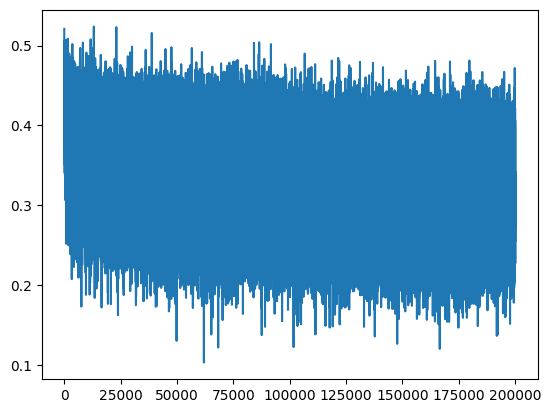

In [126]:
plt.plot(lossi)

In [127]:
# Calibraiting the batch normalization parameters at the end of training. This is necessary due to the fact that 
# by using the other elements of a batch to build one of the parameters we have fundamentally changed what the model
# is predicting. Before it was taking in the context and producing a next character. Now it is taking in the context
# and the other contexts in a batch. However, in production there is no batching. This motivates us to set a bnmean and bnstd
# for the full training set that can be used when producing output.

In [128]:
# Unecessary step when we include a running average in the training but motivates what we are trying to do

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # measure the mean/std over the full training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [135]:
@torch.no_grad() # decorator to disable gradient tracking
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = C[x] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch normalization
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalization with training set wide bn mean and std
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.065725564956665
val 2.1105117797851562


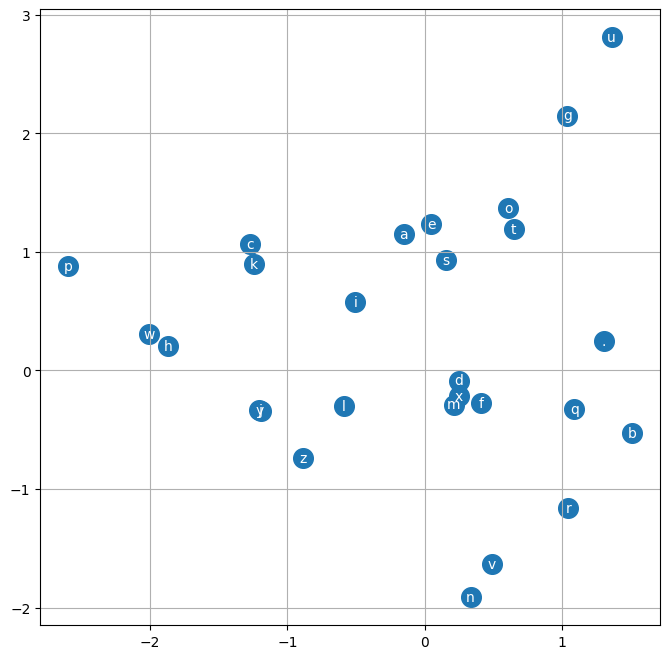

In [130]:
# When we embed the characters into two dimensions we can actually visualize the clustering of similar characters
# which I personally think is super cool.
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [134]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
with torch.no_grad():
    for _ in range(20):
        
        out = []
        context = [0] * block_size # initialize with all ...
        while True:
    
            emb = C[torch.tensor([context])] # embed characters into vectors
            embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
            hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
            hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalization with training set wide bn mean and std
            h = torch.tanh(hpreact) # hidden layer activation
            logits = h @ W2 + b2 # output layer
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
    
        print(''.join(itos[i] for i in out))

carmah.
amillie.
fitrish.
taty.
skanden.
jazhitlaymerynciereni.
ner.
kiah.
maiivon.
leigh.
ham.
joce.
quintis.
lilea.
jadbi.
wate.
madiaryn.
kar.
eveigh.
brex.


In [137]:
# SUMMARY and Reformatting as PyTorch would do it

In [208]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out)

    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with running average)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # This calculates the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True)   # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # Updating the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
        

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10    # The dimensionality of the character embedding
n_hidden = 100 # The number of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # Last Layer: we want to make it less confident
    layers[-1].gamma *= 0.1
    # Other Layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.2

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47551


In [209]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3313


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.47%
layer 5 (      Tanh): mean -0.00, std 0.65, saturated: 1.84%
layer 8 (      Tanh): mean +0.00, std 0.66, saturated: 1.41%
layer 11 (      Tanh): mean +0.01, std 0.66, saturated: 1.31%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 1.22%


Text(0.5, 1.0, 'activation distribution')

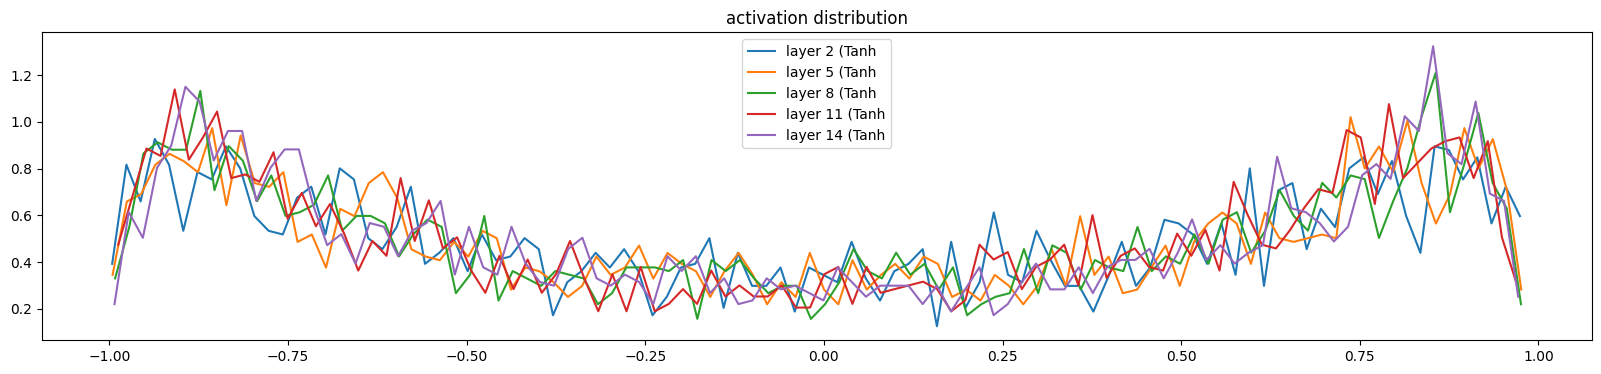

In [210]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 1.665754e-03
layer 5 (      Tanh): mean -0.000000, std 1.295932e-03
layer 8 (      Tanh): mean -0.000000, std 1.086654e-03
layer 11 (      Tanh): mean +0.000000, std 1.019121e-03
layer 14 (      Tanh): mean +0.000000, std 1.066915e-03


Text(0.5, 1.0, 'gradient distribution')

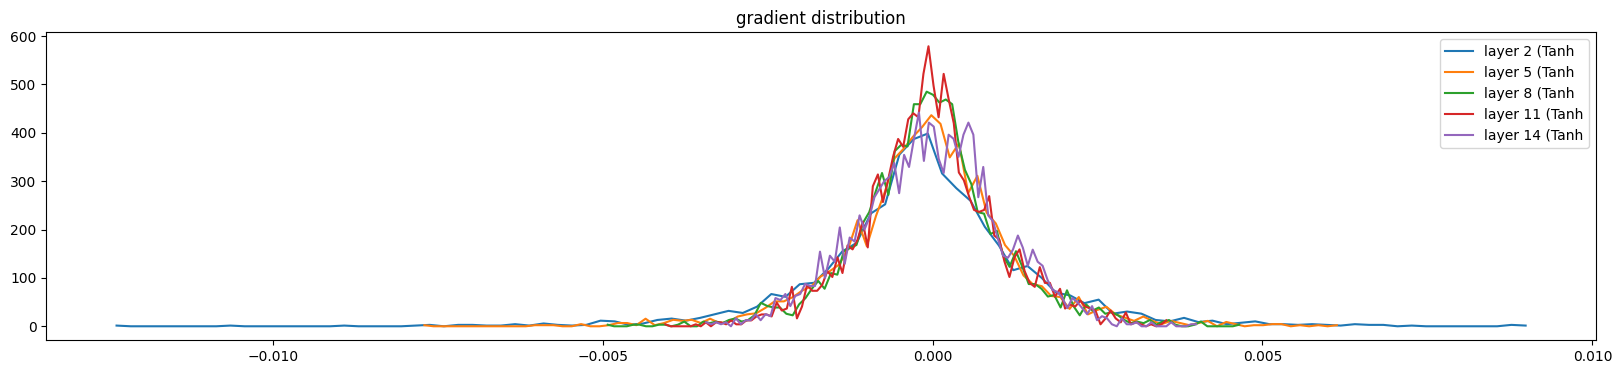

In [211]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.686477e-03 | grad:data ratio 9.677419e-03
weight  (30, 100) | mean +0.000080 | std 1.736592e-02 | grad:data ratio 2.885635e-01
weight (100, 100) | mean +0.000003 | std 7.675292e-03 | grad:data ratio 2.602364e-01
weight (100, 100) | mean +0.000028 | std 6.615367e-03 | grad:data ratio 2.442172e-01
weight (100, 100) | mean +0.000088 | std 5.769636e-03 | grad:data ratio 2.208713e-01
weight (100, 100) | mean +0.000059 | std 5.365165e-03 | grad:data ratio 2.055434e-01
weight  (100, 27) | mean +0.000220 | std 1.289045e-02 | grad:data ratio 2.952258e-01


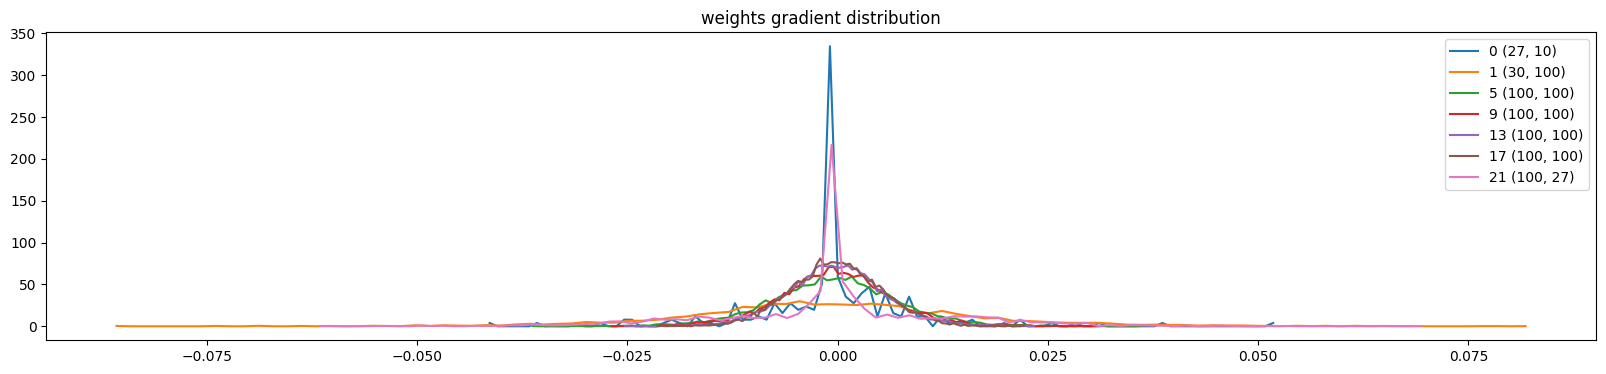

In [212]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

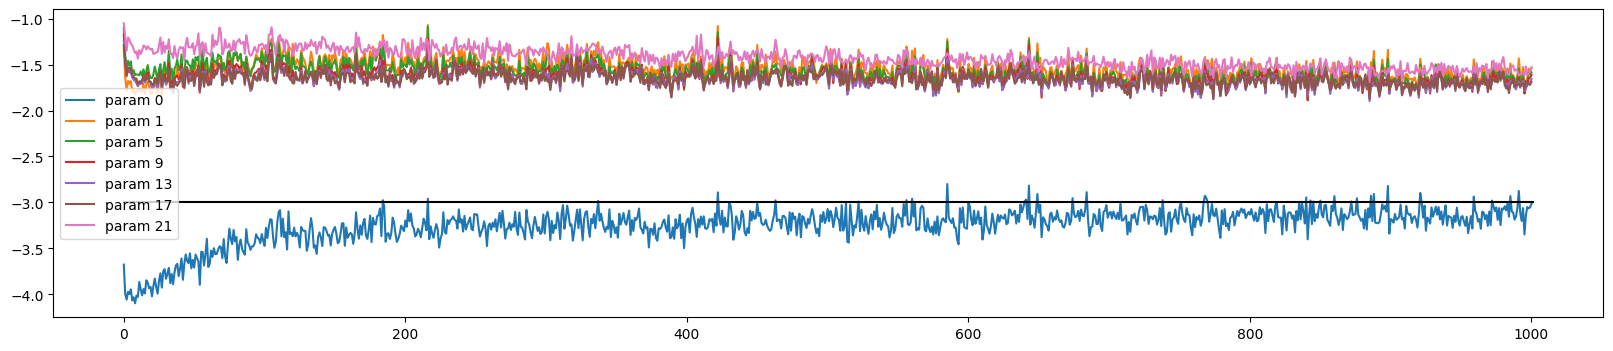

In [213]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);